<a href="https://colab.research.google.com/github/GUILLENJV/Pipeline/blob/master/PS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
df = pd.read_csv('houses_to_rent_v2_dtcl.csv')

In [ ]:
df.shape

(8995, 13)

En el proceso de ingeniería de características, es importante ver cómo se relacionan las variables de características con nuestra variable objetivo, así que vamos a trazar un mapa de calor con nuestra matriz de correlación.

<ipython-input-4-94e214150625>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='RdBu_r', linecolor='black',vmin=-1, vmax=1)


<Axes: >

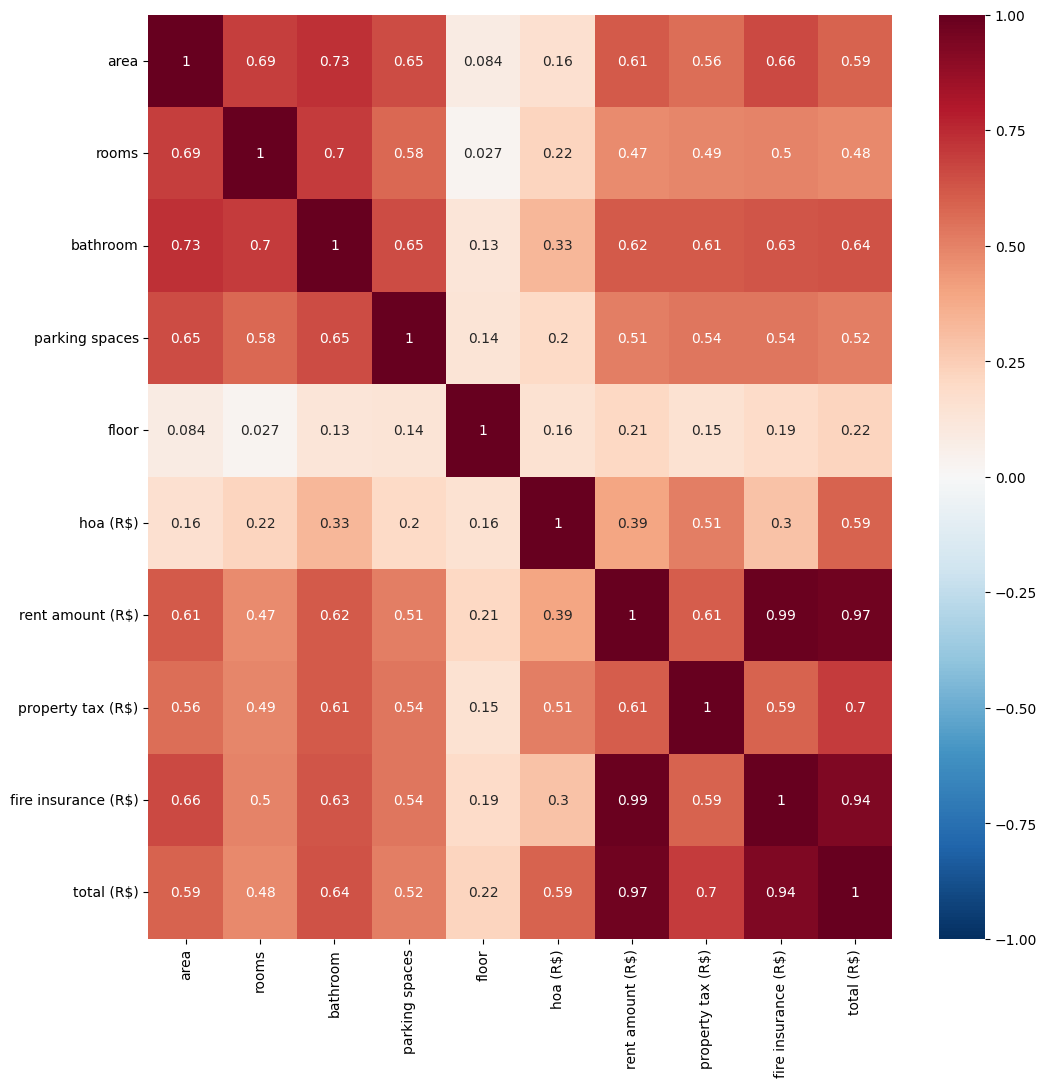

In [ ]:
# Finally, let's see the correlation between features
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r', linecolor='black',vmin=-1, vmax=1)

Podemos ver que casi todas las columnas son significativas en relación con el importe del alquiler (R$).

* Suelo no parece explicar bien nuestra variable objetivo, por lo que no la utilizaremos en nuestro proceso de ingeniería de características.
* El total es la suma de todos los valores del alquiler, el importe del alquiler y el impuesto sobre bienes inmuebles, por lo que depende del precio del alquiler. No la utilizaremos.

In [ ]:
df = df.drop(columns=['floor', 'total (R$)'])

## Creación de características
Ahora vamos a crear nuestras funciones basándonos en lo que tenemos. La creación de features es un arte en sí mismo, así que vamos a probar y experimentar.

Para este caso, ya que vamos a utilizar Pipeline de sci-kit learn, vamos a crear una clase que contendrá todas nuestras creaciones que más tarde crearemos un paso en el pipeline.

Una información clave es que no podemos crear características basadas en nuestra variable objetivo porque cuando vayamos a predecir eso en el futuro, no tendremos esa información.


In [ ]:
df.head()

,city,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
0,Belo Horizonte,42,1,1,1,not acept,furnished,470,2690,172,36
1,Belo Horizonte,64,2,2,1,acept,not furnished,352,1500,80,20
2,Belo Horizonte,80,3,2,1,acept,not furnished,0,11000,425,181
3,Belo Horizonte,200,4,2,1,not acept,not furnished,850,2550,9,34
4,Belo Horizonte,45,1,1,1,acept,not furnished,500,1631,192,12


In [ ]:
# First, let's import the BaseEstimator and TransformerMixin classes from sci-kit. Our model will inherit from these classes, since they give us pre-existing methods for free.
# Important: This variables will only exist in the Pipeline process. The original datasets will stay intact.
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('FeatureCreation initialized')

    # For the fit method, we will pass the parameter x. This is our independent variables.
    # This fit method will be called when we fit the pipeline.
    def fit(self, x, y=None):
        print('Fit FeatureCreation called')
        return self

    # Here, we will perform all of our transformations. For creating features automatic, we could create parameters in the class and pass the column names to them.
    # But in this case, since it's for this dataset specific, we will perform transformations in the column names directly into the fit method.
    # The transform method is called when we fit and when we predict using the Pipeline. And that's make sense, since we need to create our feature when we will train and when we will predict.
    def transform(self, x, y=None):
        print('Transform FeatureCreation called')
        # creating a copy to avoid changes to the original dataset
        x_ = x.copy()
        print(f'Before Transformation: {x_.shape}')
        # and now, we create everyone of our features.
        # Area power of two
        x_['area2'] = x_['area'] ** 2
        # The ratio between area and rooms
        x_['area/room'] = x_['area'] / x_['rooms']
        # The ratio between area and bathroom
        x_['area/bathroom'] = x_['area'] / x_['bathroom']
        # the sum of rooms and bathrooms
        x_['rooms+bathroom'] = x_['rooms'] + x_['bathroom']
        # the product between rooms and bathrooms
        x_['rooms*bathroom'] = x_['rooms'] * x_['bathroom']
        # the ratio between rooms and bathrooms
        x_['rooms/bathroom'] = x_['rooms'] / x_['bathroom']
        # the product between hoa and property tax
        x_['hoa*property tax'] = x_['hoa (R$)'] * x_['property tax (R$)']
        print(f'After Transformation: {x_.shape}')
        return x_

## Transformación de características
Ahora que hemos creado nuestra característica personalizada, vamos a definir un transformador de destino.

En la exploración de datos, vemos que nuestra variable objetivo está sesgada a la derecha. Una transformación común utilizada cuando esto sucede es el logaritmo de la variable.

Esta transformación será realizada por la clase TransformedTargetRegressor de sci-kit learn.

Esta transformación puede ser realizada por funciones personalizadas, pero dado que la nuestra es el logaritmo y la función exponencial, no es necesario crear una nueva.

A continuación se muestra un código de prueba para ver cómo envolvemos todo junto. El pipeline es nuestro modelo y se pasa al objeto TransformedTargetRegressor. Luego, definimos la función que se aplicará antes del ajuste, y otra que se aplicará después de predecir.

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import numpy as np

# In this step, we will pass our pipeline to the transformed target regressor.
# Now, our model it's a transformed target regressor object.

df_train = df.sample(frac=0.9,random_state=200)
df_test = df.drop(df_train.index)

cols = ['area', 'rooms', 'bathroom', 'parking spaces', 'property tax (R$)', 'fire insurance (R$)', 'hoa (R$)']
x = df_train[cols]
y = df_train['rent amount (R$)']
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

model_pipeline = Pipeline(steps=[
                    ('featurecreation', FeatureCreation()),
                    ('model', Ridge())
                ])

model = TransformedTargetRegressor(
    regressor=model_pipeline,
    func=np.log,
    inverse_func=np.exp
)

FeatureCreation initialized


In [ ]:
# Now we fit and predict.
model.fit(x_train, y_train)

FeatureCreation initialized
Fit FeatureCreation called
Transform FeatureCreation called
Before Transformation: (6476, 7)
After Transformation: (6476, 14)


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('featurecreation',
                                                      FeatureCreation()),
                                                     ('model', Ridge())]))

In [ ]:
model.predict(x_test)

Transform FeatureCreation called
Before Transformation: (1620, 7)
After Transformation: (1620, 14)


array([2101.23903621, 1113.01844552, 2779.28468075, ..., 2114.43104329,
       2795.60026153, 1842.8847265 ])

In [ ]:
df.to_csv(('houses_to_rent_v2_fteng.csv'), index=False)